## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [34]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) #array of 54 rows and 3 columns
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname) #read images in BGR format
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #change image color space: from BGR to Gray
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



        
def undistort(img,mtx,dist):
    undistorted=cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted
   

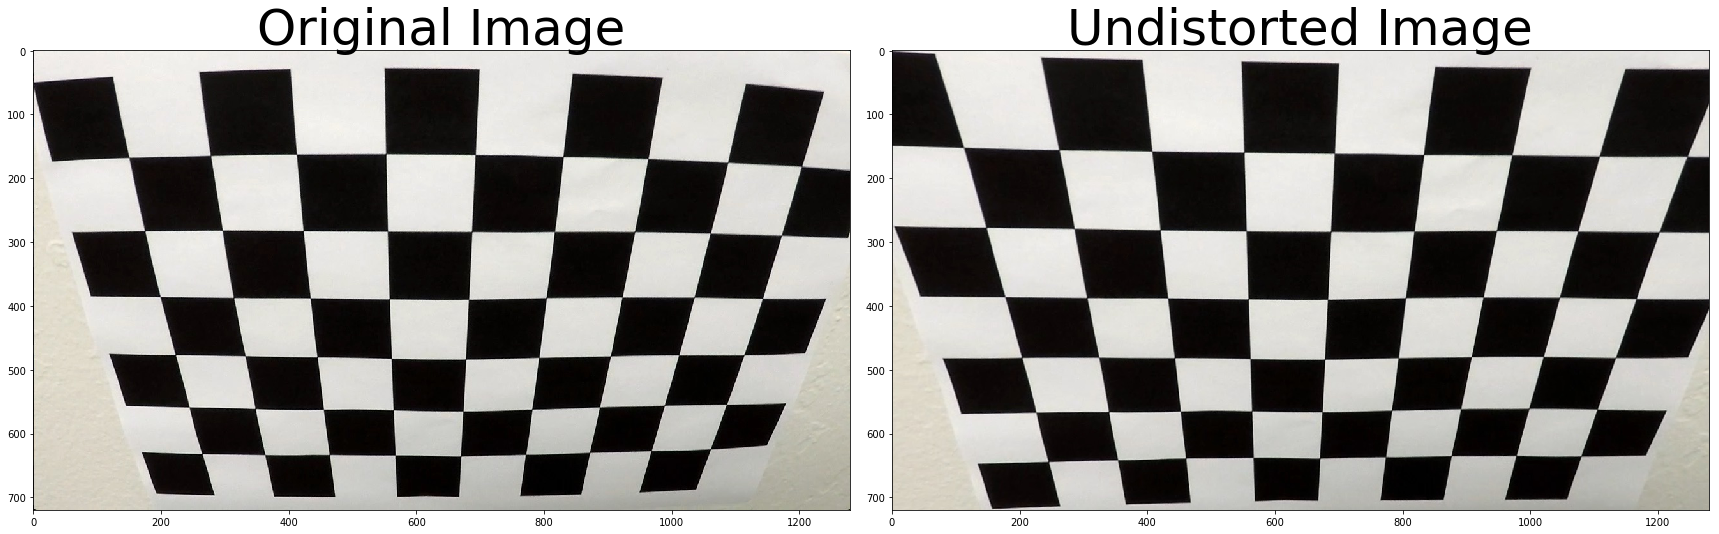

In [36]:
image = mpimg.imread('../camera_cal/calibration2.jpg') #read image in RGB format
undistorted=undistort(image,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)

plt.show()

# Unwrap the images

In [37]:
def unwrap(image):
    image_size=(image.shape[1],image.shape[0]) 
    src=np.float32([
        [272,680],
        [1047,680],
        [766,500],
        [526,500]]) 
    dst=np.float32([
        [272,680],
        [1047,680],
        [1047,500],
        [272,500]])  
    M = cv2.getPerspectiveTransform(src, dst)
    Minv=cv2.getPerspectiveTransform(dst, src)
    unwrapped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    
    return unwrapped,M,Minv

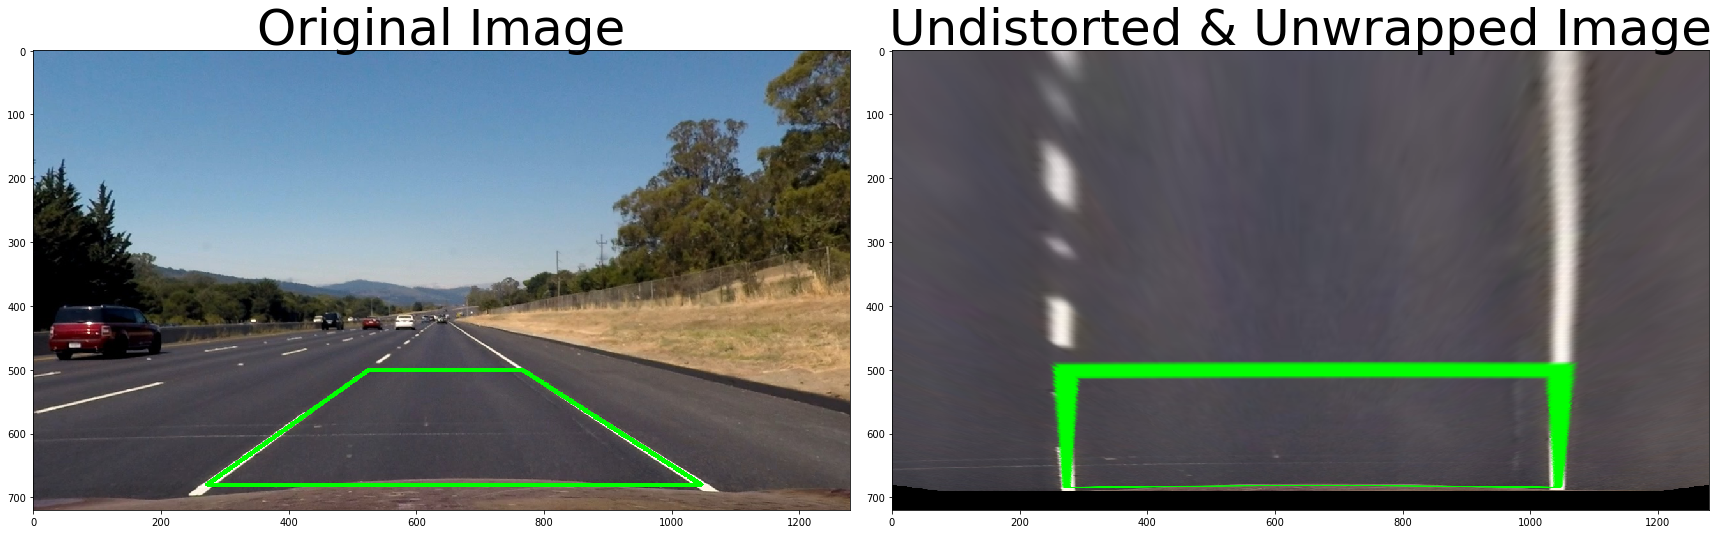

In [38]:
image = mpimg.imread('../test_images/straight_lines2.jpg') #read image in RGB format


image=undistort(image,mtx,dist)
pts=np.vstack(((272,680),(1047,680),(766,500),(526,500)))
cv2.polylines(image,[pts],  True,  (0, 255, 0),  5)

undistorted=undistort(image,mtx,dist)
unwrapped,M,Minv=unwrap(undistorted)


f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(unwrapped)
ax2.set_title('Undistorted & Unwrapped Image', fontsize=50)

plt.show()

# Define threshold detection functions: 

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(0,255)):
    #hls= cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    grey=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #s=hls[:,:,2]#saturation channel
    if orient =='x':
        sobel=cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)    
    elif orient == 'y':
        sobel=cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    else: 
        print("incorrect argument")
    abs_sobel=np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary=np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    grey=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    #s=hls[:,:,2]
    sobelx=cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel=np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary=np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel>mag_thresh[0])&(scaled_sobel<mag_thresh[1])]=1
    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    #s=hls[:,:,2]
    grey=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    direction=np.arctan2(abs_sobely,abs_sobelx)
    sbinary=np.zeros_like(direction)
    sbinary[(direction>=thresh[0])&(direction<=thresh[1])]=1
    return sbinary

def s_select(img, thresh=(100, 255)):
    # 1) Convert to HLS color space
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

def R_select(img, thresh=(100, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary

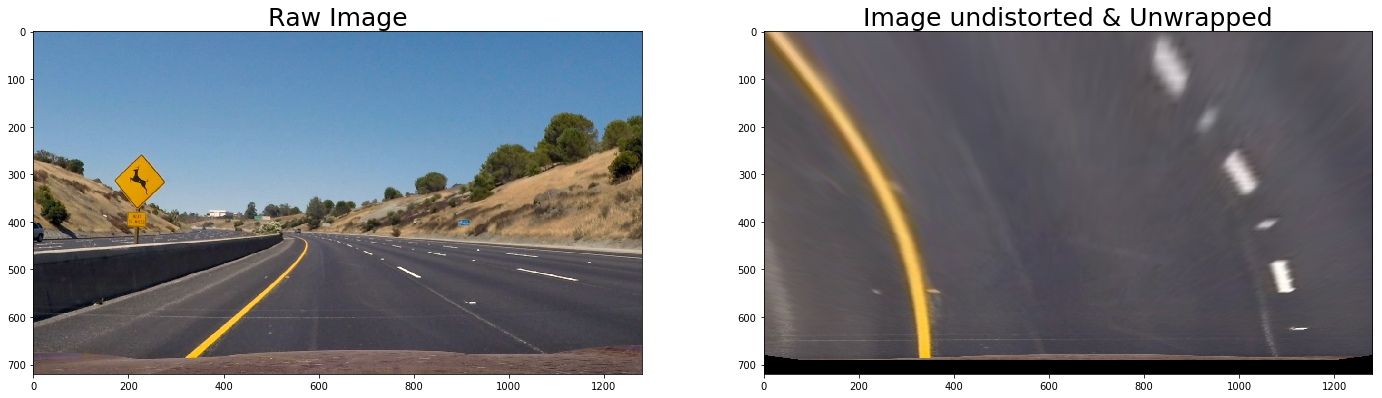

In [8]:
image = mpimg.imread('../test_images/test2.jpg') #read image in RGB format
undistorted=undistort(image,mtx,dist)
unwrapped,M,Minv=unwrap(undistorted)
gradx_binary = abs_sobel_thresh(unwrapped, orient='x', sobel_kernel=7, thresh=(20, 250))
grady_binary = abs_sobel_thresh(unwrapped, orient='y', sobel_kernel=7, thresh=(50, 250))
mag_binary = mag_thresh(unwrapped, sobel_kernel=9, mag_thresh=(30,100))
dir_binary = dir_threshold(unwrapped, sobel_kernel=15, thresh=(0.7,1.3))
sat_binary =s_select(unwrapped,thresh=(120, 255))
red_binary =R_select(unwrapped,thresh=(200, 255))

plt.figure(figsize=(24,9))

plt.subplot(1,2,1)
plt.subplot(1,2,1).set_title("Raw Image", fontsize=25)
#f.tight_layout()
plt.imshow(image)
#ax1.set_title('Original Image', fontsize=50)
plt.subplot(1,2,2)
plt.subplot(1,2,2).set_title("Image undistorted & Unwrapped", fontsize=25)
plt.imshow(unwrapped)
#ax2.set_title('Undistorted & Unwrapped Image', fontsize=50)
plt.show()


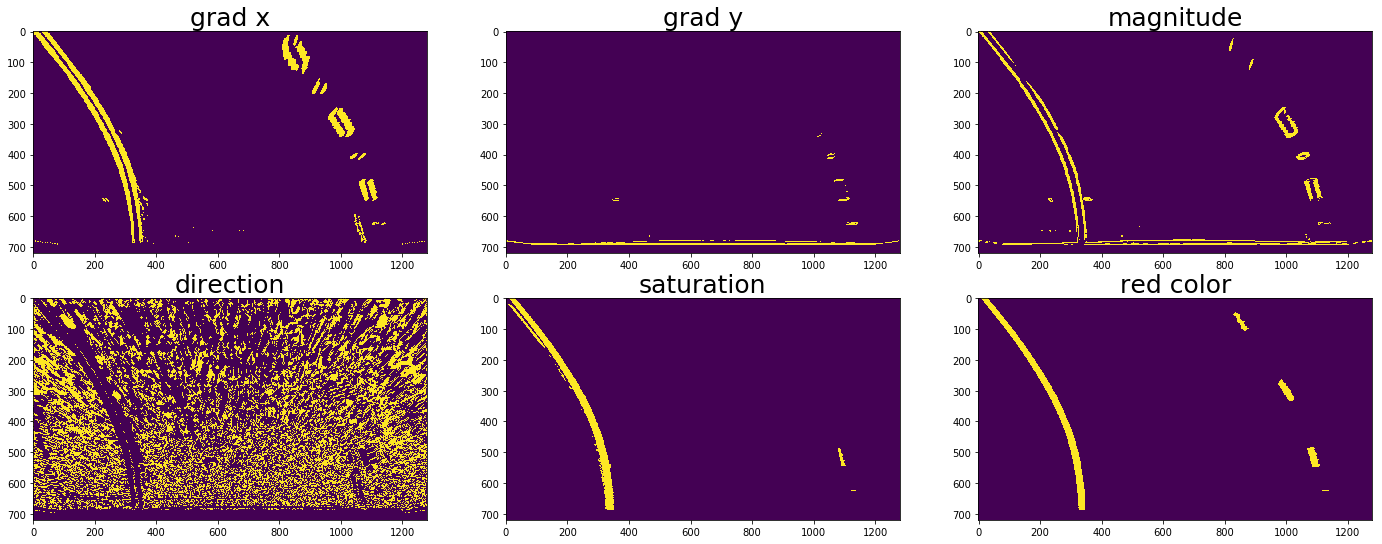

In [9]:
fig = plt.figure(num=None, figsize=(24, 9))
ax1 = fig.add_subplot(231) 
ax1.imshow(gradx_binary)
ax1.set_title('grad x', fontsize=25)

ax2 = fig.add_subplot(232) 
ax2.imshow(grady_binary)
ax2.set_title('grad y', fontsize=25)

ax3 = fig.add_subplot(233) 
ax3.imshow(mag_binary)
ax3.set_title('magnitude', fontsize=25)

ax4 = fig.add_subplot(234) 
ax4.imshow(dir_binary)
ax4.set_title('direction', fontsize=25)

ax5 = fig.add_subplot(235) 
ax5.imshow(sat_binary)
ax5.set_title('saturation', fontsize=25)

ax5 = fig.add_subplot(236) 
ax5.imshow(red_binary)
ax5.set_title('red color', fontsize=25)


plt.show()

In [10]:
def pipeline(image):
    undistorted=undistort(image,mtx,dist)
    unwrapped,M,Minv=unwrap(undistorted)
    gradx = abs_sobel_thresh(unwrapped, orient='x', sobel_kernel=7, thresh=(20, 250))
    grady = abs_sobel_thresh(unwrapped, orient='y', sobel_kernel=7, thresh=(50, 250))
    mag_binary = mag_thresh(unwrapped, sobel_kernel=9, mag_thresh=(30,100))
    dir_binary = dir_threshold(unwrapped, sobel_kernel=15, thresh=(0.7,1.3))#0.7,1.3  
    sat=s_select(unwrapped,thresh=(120, 255))
    red=R_select(unwrapped,thresh=(200, 255))
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((sat == 1)&(red == 1))|((gradx==1))] = 1
    #combined[((sat==1)|(red==1))|((gradx == 1)| (grady == 1)& (dir_binary == 1)) ] = 1
    return combined,Minv

In [12]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def fit_poly(leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds =  ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit,right_fit=fit_poly(leftx, lefty, rightx, righty)

    
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds

In [21]:
def measure_curvature_real(Binary_image,left_fit,right_fit):
# Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.04/80 # meters per pixel in y dimension
    xm_per_pix = 3.65/766 # meters per pixel in x dimension
# Define y-value where we want radius of curvature    
    h = Binary_image.shape[0]#height of the image (=y_max)
    w = Binary_image.shape[1]#width of binary image (=x_max)
# Calculate the radius of curvature 
    left_rad = ((1 + (2*left_fit[0]*h*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_rad = ((1 + (2*right_fit[0]*h*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
       
    center_x=w/2 #center of the car is considered to be in the middle of the camera image
    bottom_left_x=left_fit[0]*h**2+left_fit[1]*h+left_fit[2] #bottom x coordinate of the left line
    bottom_right_x=right_fit[0]*h**2+right_fit[1]*h+right_fit[2] #bottom x coordinate of the right line
    center_lane=(bottom_left_x+bottom_right_x)/2
    #distance from the center of the car to the center of the lane:
    dist=(center_x-center_lane)*xm_per_pix #if >0 the vehicle is offset to the right
    
    return left_rad, right_rad, dist

In [24]:
def process_image(image):
    combined,Minv=pipeline(image)
    left_fit,right_fit,left_lane_inds,right_lane_inds=find_lane_pixels(combined)
    
    wrap_zero=np.zeros_like(combined).astype(np.uint8)
    color_wrap=np.dstack((wrap_zero,wrap_zero,wrap_zero))
    
    h,w=combined.shape
    ploty=np.linspace(0,h-1,num=h)
    
    left_fit_x=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fit_x=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    pts_left=np.array([np.transpose(np.vstack([left_fit_x,ploty]))])
    pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fit_x,ploty])))])
    
    pts=np.hstack((pts_left,pts_right))
    cv2.fillPoly(color_wrap,np.int_([pts]),(0,255,0)) #fill area in green color
    cv2.polylines(color_wrap,np.int32([pts_left]),isClosed=False, color=(255,0,0),thickness=15)
    cv2.polylines(color_wrap,np.int32([pts_right]),isClosed=False, color=(0,0,255),thickness=15)

 
    left_rad, right_rad,offset=measure_curvature_real(combined,left_fit,right_fit)
    
    newwrap=cv2.warpPerspective(color_wrap,Minv,(w,h))
    result=cv2.addWeighted(image,1,newwrap,0.5,0)
    
    curve_rad=(left_rad+right_rad)/2
    if (offset>0):
        text_offset='right'
    elif (offset<0):
        text_offset='left'
    else:    
        text_offset=' '
        
    offset=abs(offset)    
    font= cv2.FONT_HERSHEY_DUPLEX
    text1= 'Radius: '+'{:04.2f}'.format(curve_rad)+'m' 
    text2='Offset: ''{:01.2f}'.format(offset)+'m '+text_offset
    
    cv2.putText(result,text1,(40,70),font,1.5,(200,255,155),2,cv2.LINE_AA)
    cv2.putText(result,text2,(40,120),font,1.5,(200,255,155),2,cv2.LINE_AA)

    return result

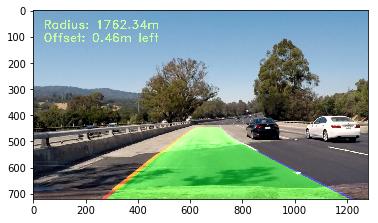

In [30]:
image = mpimg.imread('../test_images/test4.jpg') 
result=process_image(image)
plt.imshow(result)
plt.show()

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [33]:
output_filespath="../test_videos_output/"
filepath = os.path.join(output_filespath,"project_video.mp4")
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(filepath, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/project_video.mp4
[MoviePy] Writing video ../test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:55<00:00,  3.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/project_video.mp4 

